This is a _working_ notebook. See the `ccdControlIntro` notebook for a more narrative how-to. In this notebook, most cells have acquisition, processing, and plotting.

In [29]:
import fpga
import fee
import time
import clocks

import fpga.ccdFuncs as ccdFuncs
import fpga.nbFuncs as nbFuncs

import numpy as np
import scipy
import scipy.optimize as opt

# Can be useful to turn on, but remember that if you do so the entire kernel
# will stop at a prompt in a cell which hits a breakpoint or uncaiught error.
%pdb off

import matplotlib.pyplot as plt

%matplotlib inline

Automatic pdb calling has been turned OFF


In [56]:
reload(nbFuncs)

<module 'fpga.nbFuncs' from '/home/pfs/ccdFPGA/python/fpga/nbFuncs.pyc'>

In [40]:
# Initialize everything to some sane state.
reload(fee)
f = fee.FeeControl(logLevel=20)
f.powerDown()

for i in range(0):
    for v in ('3V3M', '3V3', '5VP', '5VN', '5VPpa', '5VNpa', '12VP', '12VN', '24VN', '54VP'):
        print("%s = %s" % (v, f.raw('gv,%s' % (v))))
    time.sleep(1)
    print

f.powerUp()
time.sleep(1)
for i in range(1):
    for v in ('3V3M', '3V3', '5VP', '5VN', '5VPpa', '5VNpa', '12VP', '12VN', '24VN', '54VP'):
        print("%s = %s" % (v, f.raw('gv,%s' % (v))))
    time.sleep(1)
    print



connected to FEE, revision PFS BEE Rev-, copyright JHU
SUCCESS
SUCCESS
SUCCESS
SUCCESS
SUCCESS
3V3M = 3.29
3V3 = 3.26
5VP = 4.96
5VN = -4.94
5VPpa = 4.96
5VNpa = -4.87
12VP = 11.57
12VN = -11.68
24VN = -23.02
54VP = 49.18



In [3]:
#reload(fpga)
#reload(fpga.ccd)
#reload(fpga)

ccd = fpga.CCD()
ccd.pciReset()
print "FPGA version: 0x%08x" % (ccd.peekWord(0))

FPGA version: 0xbeef0070


In [15]:
for v in ('3V3M', '3V3', '5VP', '5VN', '5VPpa', '5VNpa', '12VP', '12VN', '24VN', '54VP'):
    print("%s = %s" % (v, f.raw('gv,%s' % (v))))


3V3M = 3.28
3V3 = 3.26
5VP = 4.96
5VN = -4.94
5VPpa = 4.96
5VNpa = -4.87
12VP = 11.58
12VN = -11.68
24VN = -23.03
54VP = 49.18


In [42]:
allAmps = np.arange(8)
goodAmps = allAmps
badAmps = []

startStep = [0.01]*8

offsets, levels = gainCurve(ccd, f, stepSize=0.03999)
print offsets
print levels

plotGains(offsets, levels)

In [13]:
defOffsets = [ 0.01733254, 0.01709332, 0.01780649, 0.01694383, 0.0175229, 0.01733405, 0.01628372, 0.01802556]
f.zeroLevels()
f.setLevels(range(8), defOffsets)

In [22]:
print offs
noffs = -np.array(offs)
print noffs

f.setLevels(range(8), offs)
f.setLevels(range(8), noffs, leg='p')

[ 0.01735019  0.01711021  0.01783412  0.0169559   0.0175465   0.01736067
  0.01630232  0.01810241]
[-0.01735019 -0.01711021 -0.01783412 -0.0169559  -0.0175465  -0.01736067
 -0.01630232 -0.01810241]


In [65]:
%pdb off
#reload(nbFuncs)
offs, devs, gains = nbFuncs.tuneLevels(ccd, f, levels=1000, statCols=np.arange(100,500), 
                                       maxLoops=8, nrows=200, startStep=0.01, sigTol=3, 
                                       clockFunc=pfsClocks, legs='n')

Automatic pdb calling has been turned OFF
0050 173483912 327730    542.8    548.6    517.2    554.6    538.2    520.9    460.0    484.2  2.59  1.36  1.34  2.51  1.34  1.36  2.55  1.36 OK
0100 173483912 327780    542.8    548.6    517.2    554.5    538.2    520.9    460.0    484.2  0.74  0.77  0.74  0.78  0.74  0.76  0.72  0.74 OK
0150 173483912 327830    542.8    548.6    517.2    554.5    538.2    520.9    460.0    484.2  0.74  0.76  0.74  0.78  0.74  0.77  0.72  0.73 OK
0199 173483912 327879    542.8    548.6    517.2    554.6    538.2    521.0    460.1    484.2  0.74  0.76  0.74  0.78  0.75  0.77  0.72  0.73 OK
  0078: 00000000 -> 50da0000 on=50da0000, off=00000000
  0010: 50da0000 -> 73aa0000 on=23200000, off=00500000
  0008: 73aa0000 -> 53ea0000 on=00400000, off=20000000
  0008: 53ea0000 -> 515a0000 on=00100000, off=02a00000
  0004: 515a0000 -> 505a0000 on=00000000, off=01000000
  0004: 505a0000 -> 405a0000 on=00000000, off=10000000
  0078: 405a0000 -> 445a0000 on=04000000, off=00

readT=1.67 writeT=0.00
readT=1.67 writeT=0.00



means(0): ['549.9095', '553.9457', '523.1651', '573.3423', '544.9877', '528.8659', '460.5380', '489.7986']
devs (0): ['0.7385', '0.7300', '0.7409', '0.7616', '0.7401', '0.7366', '0.7041', '0.7404']
0: have one, need two
0: have one, need two
0: have one, need two
0: have one, need two
0: have one, need two
0: have one, need two
0: have one, need two
0: have one, need two

amps: [0, 1, 2, 3, 4, 5, 6, 7]
offs!(0): ['0.0200', '0.0200', '0.0200', '0.0200', '0.0200', '0.0200', '0.0200', '0.0200']
doffs(0): ['0.0100', '0.0100', '0.0100', '0.0100', '0.0100', '0.0100', '0.0100', '0.0100']
gains(0): ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
done(0 of 8)   : [False, False, False, False, False, False, False, False]

  0078: 00000000 -> 50da0000 on=50da0000, off=00000000
  0010: 50da0000 -> 73aa0000 on=23200000, off=00500000
  0008: 73aa0000 -> 53ea0000 on=00400000, off=20000000
  0008: 53ea0000 -> 515a0000 on=00100000, off=02a00000
  0004: 515a0000 -> 505a0

readT=1.67 writeT=0.00
readT=1.67 writeT=0.00



means(2): ['1010.3458', '990.4174', '1010.0853', '991.8017', '1009.8515', '990.1758', '1009.4577', '987.4928']
devs (2): ['0.7361', '0.7316', '0.7557', '0.7469', '0.7321', '0.7337', '0.6953', '0.7352']
7,7: dLevel/dOffset=gain -130.14/-0.00203291 = 64016.8 vs. 62783.4490869
7,7 level,mean,want,offset 990 987.493 2.50723 3.99346e-05

amps: [0, 1, 2, 3, 4, 5, 6, 7]
offs!(2): ['0.0172', '0.0170', '0.0177', '0.0167', '0.0174', '0.0172', '0.0190', '0.0180']
doffs(2): ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
gains(2): ['63555.5567', '62052.3691', '62895.9952', '62590.3070', '62550.8115', '63716.2002', '61158.9186', '62783.4491']
done(2 of 8)   : [True, True, True, True, True, True, True, False]

  0078: 00000000 -> 50da0000 on=50da0000, off=00000000
  0010: 50da0000 -> 73aa0000 on=23200000, off=00500000
  0008: 73aa0000 -> 53ea0000 on=00400000, off=20000000
  0008: 53ea0000 -> 515a0000 on=00100000, off=02a00000
  0004: 515a0000 -> 505a0000 on=00000000

readT=1.67 writeT=0.00
readT=1.67 writeT=0.00



means(4): ['1010.3063', '990.4744', '1010.1441', '991.8455', '1009.7818', '990.2107', '1009.5222', '989.8320']
devs (4): ['0.7407', '0.7327', '0.7533', '0.7329', '0.7354', '0.7305', '0.6938', '0.7456']


In [36]:
#print offs
ncols = 500
import clocks_001
import clocks_002
import clocks
reload(clocks_002)
pfsClocks = clocks_001.standardClocks
ticks, opcodes = clocks.genRowClocks(ncols, pfsClocks) 
print len(ticks)

  0078: 00000000 -> 50da0000 on=50da0000, off=00000000
  0010: 50da0000 -> 73aa0000 on=23200000, off=00500000
  0008: 73aa0000 -> 53ea0000 on=00400000, off=20000000
  0008: 53ea0000 -> 515a0000 on=00100000, off=02a00000
  0004: 515a0000 -> 505a0000 on=00000000, off=01000000
  0004: 505a0000 -> 405a0000 on=00000000, off=10000000
  0078: 405a0000 -> 445a0000 on=04000000, off=00000000
  0008: 445a0000 -> 40da0000 on=00800000, off=04000000
  0078: 40da0000 -> 48da0000 on=08000000, off=00000000
  0004: 48da0000 -> 40da0000 on=00000000, off=08000000
  0038: 40da0000 -> 50da0000 on=10000000, off=00000000
  03e8: 50da0000 -> 519b0000 on=01010000, off=00400000
  03e8: 519b0000 -> 51918000 on=00008000, off=000a0000
  03e8: 51918000 -> 51950000 on=00040000, off=00008000
  03e8: 51950000 -> 51940000 on=00000000, off=00010000
  03e8: 51940000 -> 519e0000 on=000a0000, off=00000000
  03e8: 519e0000 -> 519e0000 on=00040000, off=00000000
  0032: 519e0000 -> 51de0000 on=00400000, off=00000000
  0002: 51

Next cell does a short readout with mean & stddev stats for a few amps, the plots a row from those amps and the FFT for one amp. Fiddle with the various variables and arguments and repeat...

In [7]:
def u2i(im):
    oim = im.copy()
    w = (oim > 10000)
    #oim[w] |= (1 << 15)
    
    return oim

In [37]:
xim = (np.arange(10) - 5).astype('u2')
print xim
print u2i(xim)
print xim.astype('i2')

[65531 65532 65533 65534 65535     0     1     2     3     4]
[65531 65532 65533 65534 65535     0     1     2     3     4]
[-5 -4 -3 -2 -1  0  1  2  3  4]


# row  means   stddevs
  0078: 00000000 -> 50da0000 on=50da0000, off=00000000
  0010: 50da0000 -> 73aa0000 on=23200000, off=00500000
  0008: 73aa0000 -> 53ea0000 on=00400000, off=20000000
  0008: 53ea0000 -> 515a0000 on=00100000, off=02a00000
  0004: 515a0000 -> 505a0000 on=00000000, off=01000000
  0004: 505a0000 -> 405a0000 on=00000000, off=10000000
  0078: 405a0000 -> 445a0000 on=04000000, off=00000000
  0008: 445a0000 -> 40da0000 on=00800000, off=04000000
  0078: 40da0000 -> 48da0000 on=08000000, off=00000000
  0004: 48da0000 -> 40da0000 on=00000000, off=08000000
  0038: 40da0000 -> 50da0000 on=10000000, off=00000000
  03e8: 50da0000 -> 519b0000 on=01010000, off=00400000
  03e8: 519b0000 -> 51918000 on=00008000, off=000a0000
  03e8: 51918000 -> 51950000 on=00040000, off=00008000
  03e8: 51950000 -> 51940000 on=00000000, off=00010000
  03e8: 51940000 -> 519e0000 on=000a0000, off=00000000
  03e8: 519e0000 -> 519e0000 on=00040000, off=00000000
  0032: 519e0000 -> 51de0000 on=00400000, 

readT=1.87 writeT=0.13


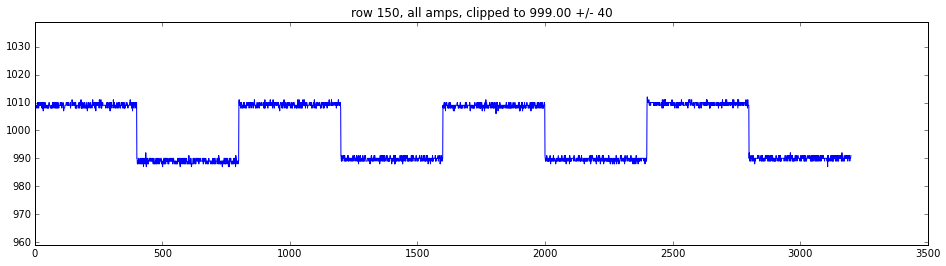

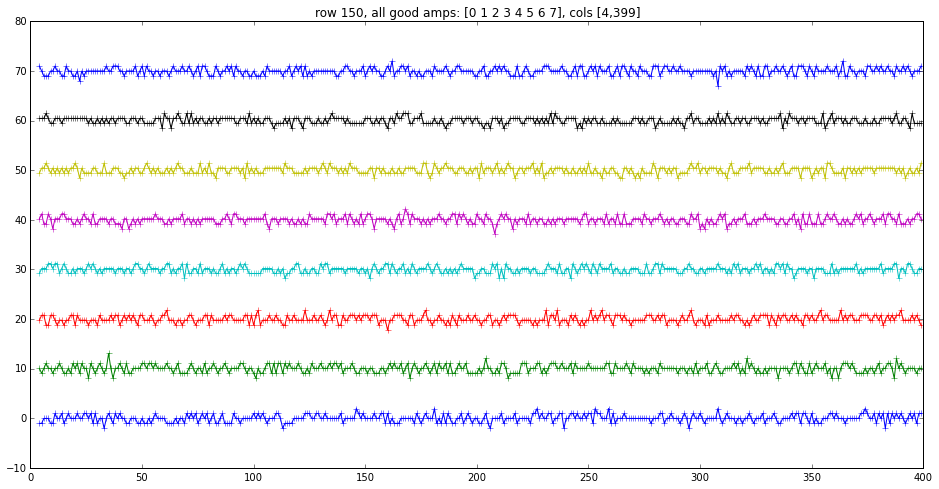

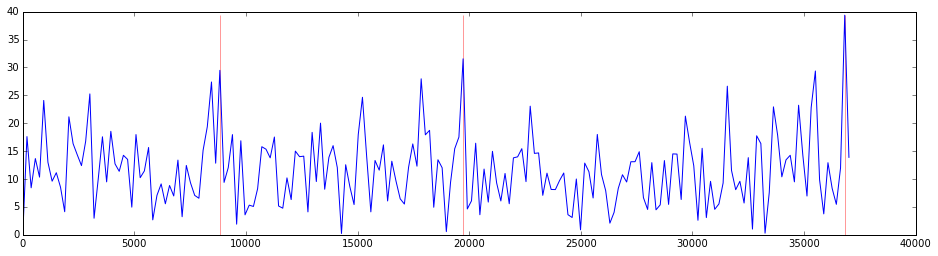

36826.6Hz -- 39.4
19728.5Hz -- 31.5
8830.9Hz -- 29.5


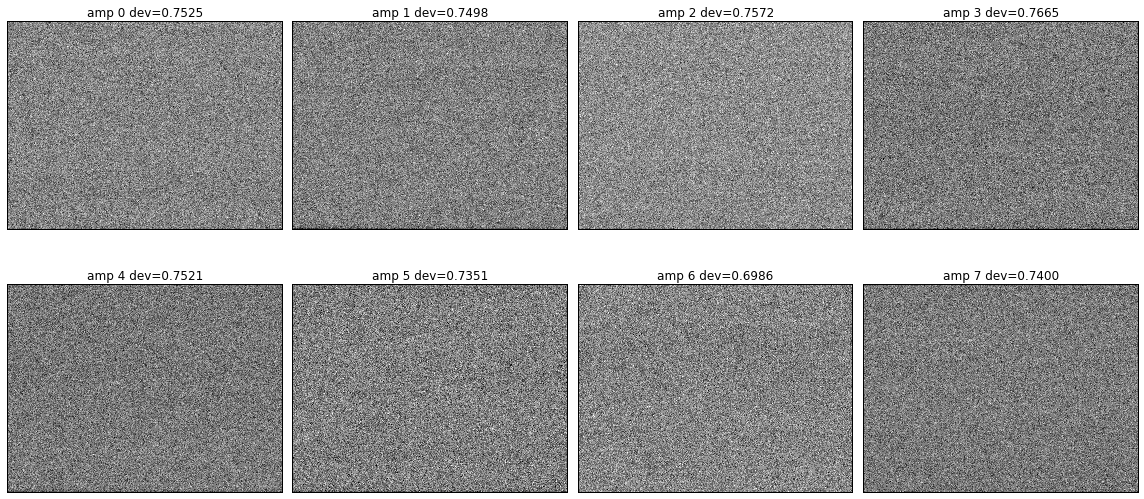

In [58]:
focusAmp = 6             # Which amp to focus on
nrows = 300                # How many rows to read out.
ncols = 400
pcols = np.arange(4,ncols)        # Which cols to plot
prow = (nrows+1)/2      # which row to plot

figWidth = 16

# read, discard, pause, re-read, to get rid of the worst ramp
argDict = dict(everyNRows=50, ampList=goodAmps, cols=pcols, ccd=ccd)
#im = ccd.readImage(nrows=nrows, ncols=ncols, rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, doSave=False)
#time.sleep(1)
print "# row  means   stddevs"
im = ccd.readImage(nrows=nrows, ncols=ncols, 
                   rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                   clockFunc=pfsClocks)

focusMask = ccd.ampidx(focusAmp, im)[pcols]

medpix = np.median(im[prow])

pixrange = 40
f1 = plt.figure(figsize=(figWidth,figWidth/4))
plt.plot(im[prow], scaley=False)
plt.axis([None, None, medpix-pixrange, medpix+pixrange])
plt.title('row %d, all amps, clipped to %0.2f +/- %d' % (prow, medpix, pixrange))
plt.show()

# Plot all the "good" amps
f2 = plt.figure(figsize=(figWidth,figWidth/2))
nbFuncs.plotAmps(im, amps=goodAmps, row=prow, cols=pcols, plotOffset=10, fig=f2)
plt.title('row %d, all good amps: %s, cols [%d,%d]' % (prow, goodAmps, 
                                                       pcols[0],pcols[-1]))

# plot the bad amps individually
for a in badAmps:
    nbFuncs.plotAmps(im, amps=[a], row=prow, cols=pcols, plotOffset=20)
    plt.title('row %d, bad amp %d' % (prow, a))


plt.figure(figsize=(figWidth, figWidth/4))
ampSeg = im[prow,focusMask]
freqs, fft, peak_ii = ccdFuncs.plotTopPeriods(ampSeg, topN=3)

#fig = plt.figure('dud', figsize=(figWidth, figWidth/2))
#p = fig.add_subplot(111)
#for i in range(10,20):
#    p.plot(im[prow-i,focusMask])

#fig = plt.figure('dud2', figsize=(figWidth, figWidth/2))
#p = fig.add_subplot(111)
#for i in range(0):
#    p.plot(im[:,focusMask[100+10*i]])


fig = plt.figure('amp_images', figsize=(figWidth, figWidth/2))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
r = 2
c = 4
for a in goodAmps:
    ampIm = im[:,ccd.ampidx(a, im)[pcols]]
    p = fig.add_subplot(r, c, a+1)
    p.xaxis.set_visible(False)
    p.yaxis.set_visible(False)

    pp = p.imshow(ampIm-ampIm.mean())
    plt.title('amp %d dev=%0.4f' % (a, ampIm.std()))
    
#fig.colorbar(pp)
plt.tight_layout()